# Sprint19

kaggleのコンペを写経することでkerasおよびU-netの使用方法を学ぶ

In [1]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


In [13]:
im_width = 128
im_height = 128
im_chan = 1
path_train = "./data/kaggle/train/"
path_test = './data/kaggle/test/'

# Data Exploration

Let's look at some data. We can see that TGS chose to use very varied data by inspecting. That is great and adresses a problem in deep learning geoscience at the moment. We build models on one type of seismic and have no idea whether it generalizes.

# データ探査

いくつかのデータを見てみましょう。 TGSは、検査によって非常に多様なデータを使用することを選択したことがわかります。 それは素晴らしいことであり、現時点では深遠な地球科学の問題に取り組んでいます。 1つのタイプの耐震モデルを構築し、それが一般化しているかどうかはわかりません。

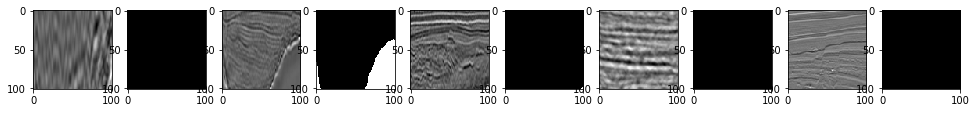

In [3]:
ids = ['1f1cc6b3a4','5b7c160d0d','6c40978ddf','7dfdf6eeb8','7e5a6e5013']
plt.figure(figsize=(20,10))
for j, img_name in enumerate(ids):
    q = j+1
    img = load_img('./data/kaggle/train/images/' + img_name + '.png')
    img_mask = load_img('./data/kaggle/train/masks/' + img_name + '.png')
    
    plt.subplot(1,2*(1+len(ids)),q*2-1)
    plt.imshow(img)
    plt.subplot(1,2*(1+len(ids)),q*2)
    plt.imshow(img_mask)
plt.show()

We have many examples without salt, as you can see by the masks that are entirely dark. That's great, an algorithm we build will then know that patches exist entirely without salt. Talk about biasing your data.

We can draw heavily on other work, instead of regurgitating the geophysics work that has been done before. I mentioned that seismic is kind of like ultrasound. So I had a look at https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277

Let's throw a Unet at our data. I am blatanly stealing from Ketil at this point. All credit goes to him and his nice code.
First we'll need to get our data into a shape that works for U-Nets. That means, it should be a power of 2. Let's do it quick and dirty for now, but eventually, consider aliasing and all that fun.

完全に暗いマスクで見ることができるように、私たちは塩のない多くの例を持っています。 それは素晴らしいことです。私たちが構築するアルゴリズムは、パッチが完全に塩なしで存在することを知ります。 あなたのデータをバイアスすることについて話してください。

これまでに行われた地球物理学の研究を逆行させるのではなく、他の研究に重点を置くことができます。 地震は超音波のようなものだと言いました。 そこで私は https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277 を見ました。

私たちのデータにUnetを投げましょう。 私はこの時点で、Ketilからblatanly盗んでいます。 すべてのクレジットは彼と彼の素敵なコードに行きます。
まず、データをUネッツで動作する形にする必要があります。 それは2の威力でなければならないということを意味しています。今は素早く汚れてみましょう。でも、最終的にはエイリアシングとそのすべての楽しみを考慮してください。

In [15]:
# 特定のディレクトリのファイルをリストで読み込む
train_ids = next(os.walk(path_train+"images"))[2]
test_ids = next(os.walk(path_test+"images"))[2]

In [5]:
# test imgase , masks のサイズ変更
X_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.bool)
print("Getting and resizing train images and masks ...")

#sys.stdout.flush()
# tqdm_notebook 進捗表示関数

for n, id_ in tqdm_notebook(enumerate(train_ids), total=len(train_ids)):
    path = path_train
    # 画像のロード
    img = load_img(path+"/images/"+id_)
    # RGBの3チャンネルとれるので1チャンネルを取得
    x = img_to_array(img)[:,:,1]
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_train[n] = x
    mask = img_to_array(load_img(path + "/masks/" + id_))[:,:,1]
    Y_train[n] = resize(mask, (128, 128, 1), mode="constant", preserve_range=True)

print("Done!")

Getting and resizing train images and masks ...


C:\Users\G2\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "



Done!


画像の可視化

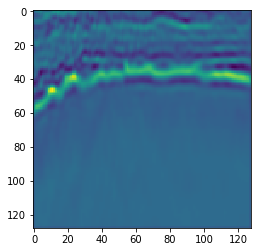

In [6]:
plt.imshow( x[:,:,0] )

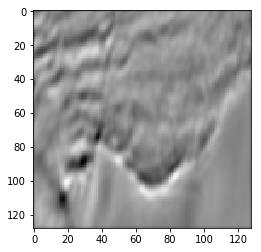

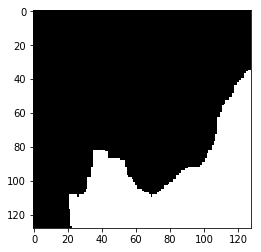

In [7]:
# check if training data looks all right
ix = random.randint(0, len(train_ids))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# Train Model
Our task, just like the segmentation task for nuclei, is evaluated on the mean IoU metric. This one isn't in keras, but obviously, we're stealing this one too from Ketil.

# Train Model
我々のタスクは、核のセグメンテーションタスクと同様に、平均IoUメトリックで評価されます。 これはケラではありませんが、明らかにKetilからもこれを盗んでいます。

In [8]:
# IoUメトリックを定義する
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

This is the fun part. Building the sequential Model. The U-Net is basically looking like an Auto-Encoder with shortcuts.

We're also sprinkling in some earlystopping to prevent overfitting. If you're running this on kaggle, this is the point, you want to have GPU support.

これは楽しい部分です。 連続モデルの構築。 U-Netは、基本的にショートカット付きの自動エンコーダのように見えます。

私たちはまた、過度の詰まりを防ぐために早期停止の中に散らばっています。 あなたがkaggleでこれを実行している場合、これがポイントです。あなたはGPUをサポートしたいと思っています。

In [9]:
# Bulid U-Net model
# shape(128, 128, 1)
inputs = Input((im_height, im_width, im_chan))
# 画素値を0～1に変換
s = Lambda(lambda x:x /255)(inputs)

# フィルタ:(3✕3) フィルタ数:8
# N_out = (N_in + 2P - F)/s +1 
#          = (128 +0 - 2)/2 + 1 
#          = 64
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)
# shape(64,64,8)

# N_in(64,64,8)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)
# N_out(32,32,16)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)
# N_out(16, 16, 32)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
# N_out(8,8,64)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)
# N_out(8, 8, 128)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)
# N_out(16,16, 64)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)
# N_out(32,32, 32)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)
# N_out(64, 64, 16)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
# N_out(128, 128, 8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1,1), activation="sigmoid")(c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  80          lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [10]:
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, callbacks=[earlystopper, checkpointer])

Train on 3600 samples, validate on 400 samples
Epoch 1/30
2984/3600 [=======================>......] - ETA: 29:47 - loss: 0.6939 - mean_iou: 0.0000e+0 - ETA: 10:02 - loss: 0.6927 - mean_iou: 0.2652    - ETA: 6:04 - loss: 0.6916 - mean_iou: 0.309 - ETA: 4:23 - loss: 0.6873 - mean_iou: 0.32 - ETA: 3:26 - loss: 0.6845 - mean_iou: 0.34 - ETA: 2:51 - loss: 0.6825 - mean_iou: 0.35 - ETA: 2:26 - loss: 0.6794 - mean_iou: 0.35 - ETA: 2:08 - loss: 0.6731 - mean_iou: 0.36 - ETA: 1:54 - loss: 0.6648 - mean_iou: 0.36 - ETA: 1:43 - loss: 0.6572 - mean_iou: 0.36 - ETA: 1:34 - loss: 0.6401 - mean_iou: 0.36 - ETA: 1:26 - loss: 0.6236 - mean_iou: 0.36 - ETA: 1:20 - loss: 0.6232 - mean_iou: 0.36 - ETA: 1:14 - loss: 0.6210 - mean_iou: 0.36 - ETA: 1:10 - loss: 0.6201 - mean_iou: 0.37 - ETA: 1:06 - loss: 0.6215 - mean_iou: 0.37 - ETA: 1:02 - loss: 0.6149 - mean_iou: 0.37 - ETA: 59s - loss: 0.6140 - mean_iou: 0.3718 - ETA: 56s - loss: 0.6136 - mean_iou: 0.372 - ETA: 54s - loss: 0.6184 - mean_iou: 0.372 - ETA

3064/3600 [========================>.....] - ETA: 13s - loss: 0.2589 - mean_iou: 0.374 - ETA: 13s - loss: 0.4627 - mean_iou: 0.374 - ETA: 13s - loss: 0.5157 - mean_iou: 0.374 - ETA: 13s - loss: 0.4967 - mean_iou: 0.374 - ETA: 13s - loss: 0.4910 - mean_iou: 0.374 - ETA: 13s - loss: 0.5095 - mean_iou: 0.374 - ETA: 13s - loss: 0.5199 - mean_iou: 0.374 - ETA: 13s - loss: 0.5281 - mean_iou: 0.374 - ETA: 13s - loss: 0.5289 - mean_iou: 0.374 - ETA: 13s - loss: 0.5186 - mean_iou: 0.374 - ETA: 13s - loss: 0.5199 - mean_iou: 0.374 - ETA: 13s - loss: 0.5099 - mean_iou: 0.374 - ETA: 13s - loss: 0.5209 - mean_iou: 0.374 - ETA: 13s - loss: 0.5201 - mean_iou: 0.374 - ETA: 13s - loss: 0.5196 - mean_iou: 0.374 - ETA: 13s - loss: 0.5133 - mean_iou: 0.374 - ETA: 12s - loss: 0.5135 - mean_iou: 0.373 - ETA: 12s - loss: 0.5098 - mean_iou: 0.373 - ETA: 12s - loss: 0.5073 - mean_iou: 0.373 - ETA: 12s - loss: 0.5102 - mean_iou: 0.373 - ETA: 12s - loss: 0.5037 - mean_iou: 0.373 - ETA: 12s - loss: 0.5024 - mean_

3600/3600 [==============================] - ETA: 1s - loss: 0.4234 - mean_iou: 0.39 - ETA: 1s - loss: 0.4226 - mean_iou: 0.39 - ETA: 1s - loss: 0.4233 - mean_iou: 0.39 - ETA: 1s - loss: 0.4226 - mean_iou: 0.39 - ETA: 1s - loss: 0.4225 - mean_iou: 0.39 - ETA: 1s - loss: 0.4221 - mean_iou: 0.39 - ETA: 1s - loss: 0.4214 - mean_iou: 0.39 - ETA: 1s - loss: 0.4213 - mean_iou: 0.39 - ETA: 1s - loss: 0.4207 - mean_iou: 0.39 - ETA: 1s - loss: 0.4197 - mean_iou: 0.39 - ETA: 1s - loss: 0.4199 - mean_iou: 0.39 - ETA: 1s - loss: 0.4192 - mean_iou: 0.39 - ETA: 1s - loss: 0.4185 - mean_iou: 0.39 - ETA: 1s - loss: 0.4181 - mean_iou: 0.39 - ETA: 1s - loss: 0.4178 - mean_iou: 0.39 - ETA: 1s - loss: 0.4176 - mean_iou: 0.39 - ETA: 1s - loss: 0.4172 - mean_iou: 0.39 - ETA: 0s - loss: 0.4162 - mean_iou: 0.39 - ETA: 0s - loss: 0.4152 - mean_iou: 0.39 - ETA: 0s - loss: 0.4147 - mean_iou: 0.39 - ETA: 0s - loss: 0.4139 - mean_iou: 0.39 - ETA: 0s - loss: 0.4136 - mean_iou: 0.39 - ETA: 0s - loss: 0.4138 - mean_i

3024/3600 [========================>.....] - ETA: 19s - loss: 0.4584 - mean_iou: 0.480 - ETA: 17s - loss: 0.4451 - mean_iou: 0.480 - ETA: 17s - loss: 0.4417 - mean_iou: 0.480 - ETA: 16s - loss: 0.4388 - mean_iou: 0.480 - ETA: 15s - loss: 0.4369 - mean_iou: 0.480 - ETA: 15s - loss: 0.4585 - mean_iou: 0.480 - ETA: 15s - loss: 0.4799 - mean_iou: 0.480 - ETA: 15s - loss: 0.5061 - mean_iou: 0.480 - ETA: 15s - loss: 0.5144 - mean_iou: 0.480 - ETA: 15s - loss: 0.5263 - mean_iou: 0.480 - ETA: 15s - loss: 0.5281 - mean_iou: 0.480 - ETA: 15s - loss: 0.5249 - mean_iou: 0.480 - ETA: 15s - loss: 0.5214 - mean_iou: 0.479 - ETA: 15s - loss: 0.5235 - mean_iou: 0.479 - ETA: 15s - loss: 0.5200 - mean_iou: 0.479 - ETA: 15s - loss: 0.5206 - mean_iou: 0.479 - ETA: 14s - loss: 0.5162 - mean_iou: 0.479 - ETA: 14s - loss: 0.5129 - mean_iou: 0.479 - ETA: 14s - loss: 0.5077 - mean_iou: 0.479 - ETA: 14s - loss: 0.4993 - mean_iou: 0.479 - ETA: 14s - loss: 0.5020 - mean_iou: 0.479 - ETA: 13s - loss: 0.4972 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.3918 - mean_iou: 0.48 - ETA: 2s - loss: 0.3920 - mean_iou: 0.48 - ETA: 2s - loss: 0.3913 - mean_iou: 0.48 - ETA: 2s - loss: 0.3908 - mean_iou: 0.48 - ETA: 2s - loss: 0.3901 - mean_iou: 0.48 - ETA: 1s - loss: 0.3892 - mean_iou: 0.48 - ETA: 1s - loss: 0.3901 - mean_iou: 0.48 - ETA: 1s - loss: 0.3907 - mean_iou: 0.48 - ETA: 1s - loss: 0.3913 - mean_iou: 0.48 - ETA: 1s - loss: 0.3910 - mean_iou: 0.48 - ETA: 1s - loss: 0.3910 - mean_iou: 0.48 - ETA: 1s - loss: 0.3908 - mean_iou: 0.48 - ETA: 1s - loss: 0.3910 - mean_iou: 0.48 - ETA: 1s - loss: 0.3909 - mean_iou: 0.48 - ETA: 1s - loss: 0.3902 - mean_iou: 0.48 - ETA: 1s - loss: 0.3899 - mean_iou: 0.48 - ETA: 1s - loss: 0.3893 - mean_iou: 0.48 - ETA: 1s - loss: 0.3907 - mean_iou: 0.48 - ETA: 1s - loss: 0.3902 - mean_iou: 0.48 - ETA: 1s - loss: 0.3896 - mean_iou: 0.48 - ETA: 0s - loss: 0.3902 - mean_iou: 0.48 - ETA: 0s - loss: 0.3901 - mean_iou: 0.48 - ETA: 0s - loss: 0.3893 - mean_i

3008/3600 [========================>.....] - ETA: 16s - loss: 0.4429 - mean_iou: 0.519 - ETA: 13s - loss: 0.3501 - mean_iou: 0.519 - ETA: 14s - loss: 0.3323 - mean_iou: 0.519 - ETA: 14s - loss: 0.3321 - mean_iou: 0.519 - ETA: 14s - loss: 0.3173 - mean_iou: 0.519 - ETA: 15s - loss: 0.3694 - mean_iou: 0.519 - ETA: 16s - loss: 0.4215 - mean_iou: 0.519 - ETA: 15s - loss: 0.3985 - mean_iou: 0.519 - ETA: 15s - loss: 0.3928 - mean_iou: 0.519 - ETA: 15s - loss: 0.3750 - mean_iou: 0.519 - ETA: 15s - loss: 0.3587 - mean_iou: 0.520 - ETA: 15s - loss: 0.3487 - mean_iou: 0.520 - ETA: 15s - loss: 0.3427 - mean_iou: 0.520 - ETA: 15s - loss: 0.3387 - mean_iou: 0.520 - ETA: 16s - loss: 0.3303 - mean_iou: 0.520 - ETA: 16s - loss: 0.3451 - mean_iou: 0.520 - ETA: 16s - loss: 0.3447 - mean_iou: 0.520 - ETA: 16s - loss: 0.3542 - mean_iou: 0.520 - ETA: 15s - loss: 0.3553 - mean_iou: 0.520 - ETA: 16s - loss: 0.3514 - mean_iou: 0.520 - ETA: 15s - loss: 0.3523 - mean_iou: 0.520 - ETA: 15s - loss: 0.3483 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.3143 - mean_iou: 0.52 - ETA: 2s - loss: 0.3131 - mean_iou: 0.52 - ETA: 2s - loss: 0.3128 - mean_iou: 0.52 - ETA: 2s - loss: 0.3120 - mean_iou: 0.52 - ETA: 2s - loss: 0.3121 - mean_iou: 0.52 - ETA: 2s - loss: 0.3126 - mean_iou: 0.52 - ETA: 1s - loss: 0.3120 - mean_iou: 0.52 - ETA: 1s - loss: 0.3119 - mean_iou: 0.52 - ETA: 1s - loss: 0.3117 - mean_iou: 0.52 - ETA: 1s - loss: 0.3112 - mean_iou: 0.52 - ETA: 1s - loss: 0.3114 - mean_iou: 0.52 - ETA: 1s - loss: 0.3112 - mean_iou: 0.52 - ETA: 1s - loss: 0.3105 - mean_iou: 0.52 - ETA: 1s - loss: 0.3115 - mean_iou: 0.52 - ETA: 1s - loss: 0.3111 - mean_iou: 0.52 - ETA: 1s - loss: 0.3125 - mean_iou: 0.52 - ETA: 1s - loss: 0.3123 - mean_iou: 0.52 - ETA: 1s - loss: 0.3119 - mean_iou: 0.52 - ETA: 1s - loss: 0.3129 - mean_iou: 0.52 - ETA: 1s - loss: 0.3140 - mean_iou: 0.52 - ETA: 1s - loss: 0.3138 - mean_iou: 0.52 - ETA: 0s - loss: 0.3137 - mean_iou: 0.52 - ETA: 0s - loss: 0.3139 - mean_i

3064/3600 [========================>.....] - ETA: 13s - loss: 0.4965 - mean_iou: 0.555 - ETA: 13s - loss: 0.4885 - mean_iou: 0.555 - ETA: 13s - loss: 0.3780 - mean_iou: 0.555 - ETA: 13s - loss: 0.3737 - mean_iou: 0.555 - ETA: 13s - loss: 0.3350 - mean_iou: 0.555 - ETA: 13s - loss: 0.3649 - mean_iou: 0.555 - ETA: 13s - loss: 0.3590 - mean_iou: 0.555 - ETA: 13s - loss: 0.3420 - mean_iou: 0.555 - ETA: 13s - loss: 0.3520 - mean_iou: 0.555 - ETA: 13s - loss: 0.3601 - mean_iou: 0.555 - ETA: 12s - loss: 0.3442 - mean_iou: 0.555 - ETA: 12s - loss: 0.3280 - mean_iou: 0.555 - ETA: 12s - loss: 0.3422 - mean_iou: 0.555 - ETA: 12s - loss: 0.3444 - mean_iou: 0.555 - ETA: 12s - loss: 0.3365 - mean_iou: 0.555 - ETA: 12s - loss: 0.3269 - mean_iou: 0.555 - ETA: 12s - loss: 0.3193 - mean_iou: 0.555 - ETA: 12s - loss: 0.3216 - mean_iou: 0.555 - ETA: 12s - loss: 0.3159 - mean_iou: 0.555 - ETA: 12s - loss: 0.3150 - mean_iou: 0.555 - ETA: 12s - loss: 0.3185 - mean_iou: 0.555 - ETA: 12s - loss: 0.3120 - mean_

3600/3600 [==============================] - ETA: 1s - loss: 0.2991 - mean_iou: 0.56 - ETA: 1s - loss: 0.2992 - mean_iou: 0.56 - ETA: 1s - loss: 0.2986 - mean_iou: 0.56 - ETA: 1s - loss: 0.2987 - mean_iou: 0.56 - ETA: 1s - loss: 0.2980 - mean_iou: 0.56 - ETA: 1s - loss: 0.2971 - mean_iou: 0.56 - ETA: 1s - loss: 0.2972 - mean_iou: 0.56 - ETA: 1s - loss: 0.2968 - mean_iou: 0.56 - ETA: 1s - loss: 0.2970 - mean_iou: 0.56 - ETA: 1s - loss: 0.2970 - mean_iou: 0.56 - ETA: 1s - loss: 0.2971 - mean_iou: 0.56 - ETA: 1s - loss: 0.2972 - mean_iou: 0.56 - ETA: 1s - loss: 0.2965 - mean_iou: 0.56 - ETA: 1s - loss: 0.2964 - mean_iou: 0.56 - ETA: 1s - loss: 0.2969 - mean_iou: 0.56 - ETA: 1s - loss: 0.2968 - mean_iou: 0.56 - ETA: 0s - loss: 0.2973 - mean_iou: 0.56 - ETA: 0s - loss: 0.2978 - mean_iou: 0.56 - ETA: 0s - loss: 0.2970 - mean_iou: 0.56 - ETA: 0s - loss: 0.2976 - mean_iou: 0.56 - ETA: 0s - loss: 0.2974 - mean_iou: 0.56 - ETA: 0s - loss: 0.2972 - mean_iou: 0.56 - ETA: 0s - loss: 0.2965 - mean_i

3064/3600 [========================>.....] - ETA: 15s - loss: 0.2531 - mean_iou: 0.586 - ETA: 14s - loss: 0.2103 - mean_iou: 0.586 - ETA: 13s - loss: 0.2006 - mean_iou: 0.586 - ETA: 13s - loss: 0.2382 - mean_iou: 0.586 - ETA: 13s - loss: 0.2341 - mean_iou: 0.586 - ETA: 13s - loss: 0.2298 - mean_iou: 0.586 - ETA: 13s - loss: 0.2293 - mean_iou: 0.586 - ETA: 13s - loss: 0.2207 - mean_iou: 0.586 - ETA: 13s - loss: 0.2113 - mean_iou: 0.586 - ETA: 13s - loss: 0.2390 - mean_iou: 0.586 - ETA: 13s - loss: 0.2484 - mean_iou: 0.586 - ETA: 13s - loss: 0.2495 - mean_iou: 0.586 - ETA: 13s - loss: 0.2717 - mean_iou: 0.586 - ETA: 12s - loss: 0.2675 - mean_iou: 0.586 - ETA: 12s - loss: 0.2838 - mean_iou: 0.586 - ETA: 12s - loss: 0.2951 - mean_iou: 0.586 - ETA: 12s - loss: 0.2946 - mean_iou: 0.586 - ETA: 12s - loss: 0.2879 - mean_iou: 0.586 - ETA: 12s - loss: 0.2865 - mean_iou: 0.586 - ETA: 12s - loss: 0.2891 - mean_iou: 0.586 - ETA: 12s - loss: 0.2854 - mean_iou: 0.586 - ETA: 12s - loss: 0.2812 - mean_

3600/3600 [==============================] - ETA: 1s - loss: 0.2697 - mean_iou: 0.59 - ETA: 1s - loss: 0.2693 - mean_iou: 0.59 - ETA: 1s - loss: 0.2694 - mean_iou: 0.59 - ETA: 1s - loss: 0.2698 - mean_iou: 0.59 - ETA: 1s - loss: 0.2699 - mean_iou: 0.59 - ETA: 1s - loss: 0.2694 - mean_iou: 0.59 - ETA: 1s - loss: 0.2692 - mean_iou: 0.59 - ETA: 1s - loss: 0.2709 - mean_iou: 0.59 - ETA: 1s - loss: 0.2716 - mean_iou: 0.59 - ETA: 1s - loss: 0.2710 - mean_iou: 0.59 - ETA: 1s - loss: 0.2707 - mean_iou: 0.59 - ETA: 1s - loss: 0.2704 - mean_iou: 0.59 - ETA: 1s - loss: 0.2705 - mean_iou: 0.59 - ETA: 1s - loss: 0.2713 - mean_iou: 0.59 - ETA: 1s - loss: 0.2708 - mean_iou: 0.59 - ETA: 1s - loss: 0.2702 - mean_iou: 0.59 - ETA: 0s - loss: 0.2706 - mean_iou: 0.59 - ETA: 0s - loss: 0.2712 - mean_iou: 0.59 - ETA: 0s - loss: 0.2712 - mean_iou: 0.59 - ETA: 0s - loss: 0.2708 - mean_iou: 0.59 - ETA: 0s - loss: 0.2701 - mean_iou: 0.59 - ETA: 0s - loss: 0.2698 - mean_iou: 0.59 - ETA: 0s - loss: 0.2692 - mean_i

2968/3600 [=======================>......] - ETA: 13s - loss: 0.1826 - mean_iou: 0.611 - ETA: 13s - loss: 0.1170 - mean_iou: 0.611 - ETA: 13s - loss: 0.1976 - mean_iou: 0.611 - ETA: 13s - loss: 0.2152 - mean_iou: 0.611 - ETA: 14s - loss: 0.2334 - mean_iou: 0.611 - ETA: 13s - loss: 0.2317 - mean_iou: 0.611 - ETA: 13s - loss: 0.2172 - mean_iou: 0.611 - ETA: 13s - loss: 0.2394 - mean_iou: 0.611 - ETA: 13s - loss: 0.2247 - mean_iou: 0.611 - ETA: 13s - loss: 0.2315 - mean_iou: 0.611 - ETA: 13s - loss: 0.2355 - mean_iou: 0.611 - ETA: 13s - loss: 0.2265 - mean_iou: 0.611 - ETA: 13s - loss: 0.2208 - mean_iou: 0.611 - ETA: 13s - loss: 0.2196 - mean_iou: 0.611 - ETA: 13s - loss: 0.2162 - mean_iou: 0.611 - ETA: 13s - loss: 0.2143 - mean_iou: 0.611 - ETA: 13s - loss: 0.2172 - mean_iou: 0.611 - ETA: 12s - loss: 0.2101 - mean_iou: 0.611 - ETA: 12s - loss: 0.2136 - mean_iou: 0.611 - ETA: 12s - loss: 0.2135 - mean_iou: 0.611 - ETA: 12s - loss: 0.2109 - mean_iou: 0.611 - ETA: 12s - loss: 0.2130 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.2339 - mean_iou: 0.61 - ETA: 2s - loss: 0.2347 - mean_iou: 0.61 - ETA: 2s - loss: 0.2344 - mean_iou: 0.61 - ETA: 2s - loss: 0.2354 - mean_iou: 0.61 - ETA: 2s - loss: 0.2354 - mean_iou: 0.61 - ETA: 2s - loss: 0.2352 - mean_iou: 0.61 - ETA: 2s - loss: 0.2347 - mean_iou: 0.61 - ETA: 2s - loss: 0.2348 - mean_iou: 0.61 - ETA: 2s - loss: 0.2351 - mean_iou: 0.61 - ETA: 2s - loss: 0.2351 - mean_iou: 0.61 - ETA: 1s - loss: 0.2346 - mean_iou: 0.61 - ETA: 1s - loss: 0.2353 - mean_iou: 0.61 - ETA: 1s - loss: 0.2346 - mean_iou: 0.61 - ETA: 1s - loss: 0.2344 - mean_iou: 0.61 - ETA: 1s - loss: 0.2346 - mean_iou: 0.61 - ETA: 1s - loss: 0.2351 - mean_iou: 0.61 - ETA: 1s - loss: 0.2353 - mean_iou: 0.61 - ETA: 1s - loss: 0.2355 - mean_iou: 0.61 - ETA: 1s - loss: 0.2354 - mean_iou: 0.61 - ETA: 1s - loss: 0.2356 - mean_iou: 0.61 - ETA: 1s - loss: 0.2356 - mean_iou: 0.61 - ETA: 1s - loss: 0.2352 - mean_iou: 0.61 - ETA: 1s - loss: 0.2358 - mean_i

3008/3600 [========================>.....] - ETA: 15s - loss: 0.1028 - mean_iou: 0.629 - ETA: 15s - loss: 0.1919 - mean_iou: 0.629 - ETA: 14s - loss: 0.1812 - mean_iou: 0.629 - ETA: 14s - loss: 0.1731 - mean_iou: 0.629 - ETA: 15s - loss: 0.2134 - mean_iou: 0.629 - ETA: 15s - loss: 0.2112 - mean_iou: 0.629 - ETA: 15s - loss: 0.2076 - mean_iou: 0.629 - ETA: 15s - loss: 0.2171 - mean_iou: 0.629 - ETA: 15s - loss: 0.2251 - mean_iou: 0.629 - ETA: 15s - loss: 0.2297 - mean_iou: 0.629 - ETA: 15s - loss: 0.2153 - mean_iou: 0.629 - ETA: 15s - loss: 0.2263 - mean_iou: 0.629 - ETA: 16s - loss: 0.2259 - mean_iou: 0.629 - ETA: 15s - loss: 0.2335 - mean_iou: 0.629 - ETA: 16s - loss: 0.2313 - mean_iou: 0.629 - ETA: 16s - loss: 0.2245 - mean_iou: 0.629 - ETA: 15s - loss: 0.2190 - mean_iou: 0.629 - ETA: 15s - loss: 0.2223 - mean_iou: 0.629 - ETA: 15s - loss: 0.2186 - mean_iou: 0.629 - ETA: 15s - loss: 0.2223 - mean_iou: 0.629 - ETA: 15s - loss: 0.2254 - mean_iou: 0.629 - ETA: 15s - loss: 0.2211 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.2203 - mean_iou: 0.63 - ETA: 2s - loss: 0.2201 - mean_iou: 0.63 - ETA: 2s - loss: 0.2199 - mean_iou: 0.63 - ETA: 2s - loss: 0.2197 - mean_iou: 0.63 - ETA: 2s - loss: 0.2192 - mean_iou: 0.63 - ETA: 2s - loss: 0.2189 - mean_iou: 0.63 - ETA: 2s - loss: 0.2183 - mean_iou: 0.63 - ETA: 1s - loss: 0.2183 - mean_iou: 0.63 - ETA: 1s - loss: 0.2178 - mean_iou: 0.63 - ETA: 1s - loss: 0.2171 - mean_iou: 0.63 - ETA: 1s - loss: 0.2187 - mean_iou: 0.63 - ETA: 1s - loss: 0.2190 - mean_iou: 0.63 - ETA: 1s - loss: 0.2192 - mean_iou: 0.63 - ETA: 1s - loss: 0.2188 - mean_iou: 0.63 - ETA: 1s - loss: 0.2195 - mean_iou: 0.63 - ETA: 1s - loss: 0.2190 - mean_iou: 0.63 - ETA: 1s - loss: 0.2194 - mean_iou: 0.63 - ETA: 1s - loss: 0.2190 - mean_iou: 0.63 - ETA: 1s - loss: 0.2186 - mean_iou: 0.63 - ETA: 1s - loss: 0.2182 - mean_iou: 0.63 - ETA: 1s - loss: 0.2187 - mean_iou: 0.63 - ETA: 1s - loss: 0.2188 - mean_iou: 0.63 - ETA: 0s - loss: 0.2191 - mean_i

3040/3600 [========================>.....] - ETA: 17s - loss: 0.3060 - mean_iou: 0.646 - ETA: 18s - loss: 0.2830 - mean_iou: 0.646 - ETA: 17s - loss: 0.2427 - mean_iou: 0.646 - ETA: 17s - loss: 0.2735 - mean_iou: 0.646 - ETA: 17s - loss: 0.2326 - mean_iou: 0.646 - ETA: 16s - loss: 0.2294 - mean_iou: 0.646 - ETA: 16s - loss: 0.2411 - mean_iou: 0.646 - ETA: 16s - loss: 0.2380 - mean_iou: 0.646 - ETA: 16s - loss: 0.2404 - mean_iou: 0.646 - ETA: 16s - loss: 0.2392 - mean_iou: 0.646 - ETA: 16s - loss: 0.2488 - mean_iou: 0.646 - ETA: 16s - loss: 0.2384 - mean_iou: 0.646 - ETA: 16s - loss: 0.2321 - mean_iou: 0.647 - ETA: 15s - loss: 0.2261 - mean_iou: 0.647 - ETA: 15s - loss: 0.2255 - mean_iou: 0.647 - ETA: 15s - loss: 0.2207 - mean_iou: 0.647 - ETA: 15s - loss: 0.2214 - mean_iou: 0.647 - ETA: 14s - loss: 0.2177 - mean_iou: 0.647 - ETA: 14s - loss: 0.2128 - mean_iou: 0.647 - ETA: 14s - loss: 0.2084 - mean_iou: 0.647 - ETA: 14s - loss: 0.2036 - mean_iou: 0.647 - ETA: 14s - loss: 0.2049 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.2118 - mean_iou: 0.64 - ETA: 2s - loss: 0.2114 - mean_iou: 0.64 - ETA: 2s - loss: 0.2109 - mean_iou: 0.64 - ETA: 2s - loss: 0.2115 - mean_iou: 0.64 - ETA: 2s - loss: 0.2114 - mean_iou: 0.64 - ETA: 1s - loss: 0.2112 - mean_iou: 0.64 - ETA: 1s - loss: 0.2119 - mean_iou: 0.64 - ETA: 1s - loss: 0.2116 - mean_iou: 0.64 - ETA: 1s - loss: 0.2109 - mean_iou: 0.64 - ETA: 1s - loss: 0.2108 - mean_iou: 0.64 - ETA: 1s - loss: 0.2108 - mean_iou: 0.64 - ETA: 1s - loss: 0.2116 - mean_iou: 0.64 - ETA: 1s - loss: 0.2113 - mean_iou: 0.64 - ETA: 1s - loss: 0.2112 - mean_iou: 0.64 - ETA: 1s - loss: 0.2111 - mean_iou: 0.65 - ETA: 1s - loss: 0.2108 - mean_iou: 0.65 - ETA: 1s - loss: 0.2109 - mean_iou: 0.65 - ETA: 1s - loss: 0.2105 - mean_iou: 0.65 - ETA: 1s - loss: 0.2103 - mean_iou: 0.65 - ETA: 1s - loss: 0.2096 - mean_iou: 0.65 - ETA: 0s - loss: 0.2093 - mean_iou: 0.65 - ETA: 0s - loss: 0.2092 - mean_iou: 0.65 - ETA: 0s - loss: 0.2091 - mean_i

3008/3600 [========================>.....] - ETA: 14s - loss: 0.1227 - mean_iou: 0.661 - ETA: 13s - loss: 0.2497 - mean_iou: 0.661 - ETA: 13s - loss: 0.2114 - mean_iou: 0.661 - ETA: 13s - loss: 0.1753 - mean_iou: 0.661 - ETA: 12s - loss: 0.1533 - mean_iou: 0.661 - ETA: 12s - loss: 0.1719 - mean_iou: 0.661 - ETA: 12s - loss: 0.1800 - mean_iou: 0.661 - ETA: 12s - loss: 0.1703 - mean_iou: 0.661 - ETA: 13s - loss: 0.1653 - mean_iou: 0.661 - ETA: 13s - loss: 0.1610 - mean_iou: 0.661 - ETA: 13s - loss: 0.1549 - mean_iou: 0.661 - ETA: 13s - loss: 0.1526 - mean_iou: 0.661 - ETA: 13s - loss: 0.1651 - mean_iou: 0.661 - ETA: 13s - loss: 0.1683 - mean_iou: 0.661 - ETA: 13s - loss: 0.1626 - mean_iou: 0.661 - ETA: 13s - loss: 0.1628 - mean_iou: 0.661 - ETA: 13s - loss: 0.1838 - mean_iou: 0.661 - ETA: 13s - loss: 0.1866 - mean_iou: 0.661 - ETA: 13s - loss: 0.1928 - mean_iou: 0.661 - ETA: 13s - loss: 0.1907 - mean_iou: 0.661 - ETA: 13s - loss: 0.1865 - mean_iou: 0.661 - ETA: 13s - loss: 0.1857 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.1971 - mean_iou: 0.66 - ETA: 2s - loss: 0.1964 - mean_iou: 0.66 - ETA: 2s - loss: 0.1965 - mean_iou: 0.66 - ETA: 2s - loss: 0.1958 - mean_iou: 0.66 - ETA: 2s - loss: 0.1957 - mean_iou: 0.66 - ETA: 2s - loss: 0.1959 - mean_iou: 0.66 - ETA: 2s - loss: 0.1957 - mean_iou: 0.66 - ETA: 2s - loss: 0.1953 - mean_iou: 0.66 - ETA: 1s - loss: 0.1954 - mean_iou: 0.66 - ETA: 1s - loss: 0.1952 - mean_iou: 0.66 - ETA: 1s - loss: 0.1956 - mean_iou: 0.66 - ETA: 1s - loss: 0.1952 - mean_iou: 0.66 - ETA: 1s - loss: 0.1949 - mean_iou: 0.66 - ETA: 1s - loss: 0.1944 - mean_iou: 0.66 - ETA: 1s - loss: 0.1943 - mean_iou: 0.66 - ETA: 1s - loss: 0.1944 - mean_iou: 0.66 - ETA: 1s - loss: 0.1947 - mean_iou: 0.66 - ETA: 1s - loss: 0.1943 - mean_iou: 0.66 - ETA: 1s - loss: 0.1940 - mean_iou: 0.66 - ETA: 1s - loss: 0.1939 - mean_iou: 0.66 - ETA: 1s - loss: 0.1937 - mean_iou: 0.66 - ETA: 1s - loss: 0.1934 - mean_iou: 0.66 - ETA: 1s - loss: 0.1931 - mean_i

3048/3600 [========================>.....] - ETA: 12s - loss: 0.4482 - mean_iou: 0.674 - ETA: 12s - loss: 0.1979 - mean_iou: 0.674 - ETA: 14s - loss: 0.1979 - mean_iou: 0.674 - ETA: 14s - loss: 0.2371 - mean_iou: 0.674 - ETA: 14s - loss: 0.2451 - mean_iou: 0.674 - ETA: 14s - loss: 0.2405 - mean_iou: 0.674 - ETA: 14s - loss: 0.2177 - mean_iou: 0.674 - ETA: 14s - loss: 0.2032 - mean_iou: 0.674 - ETA: 14s - loss: 0.1884 - mean_iou: 0.674 - ETA: 14s - loss: 0.1916 - mean_iou: 0.674 - ETA: 13s - loss: 0.1812 - mean_iou: 0.674 - ETA: 13s - loss: 0.1790 - mean_iou: 0.674 - ETA: 13s - loss: 0.1786 - mean_iou: 0.674 - ETA: 13s - loss: 0.1791 - mean_iou: 0.675 - ETA: 13s - loss: 0.1779 - mean_iou: 0.675 - ETA: 13s - loss: 0.1832 - mean_iou: 0.675 - ETA: 13s - loss: 0.1891 - mean_iou: 0.675 - ETA: 13s - loss: 0.1844 - mean_iou: 0.675 - ETA: 13s - loss: 0.1840 - mean_iou: 0.675 - ETA: 13s - loss: 0.1927 - mean_iou: 0.675 - ETA: 13s - loss: 0.1970 - mean_iou: 0.675 - ETA: 13s - loss: 0.1970 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.1784 - mean_iou: 0.67 - ETA: 2s - loss: 0.1783 - mean_iou: 0.67 - ETA: 2s - loss: 0.1776 - mean_iou: 0.67 - ETA: 1s - loss: 0.1772 - mean_iou: 0.67 - ETA: 1s - loss: 0.1767 - mean_iou: 0.67 - ETA: 1s - loss: 0.1763 - mean_iou: 0.67 - ETA: 1s - loss: 0.1759 - mean_iou: 0.67 - ETA: 1s - loss: 0.1754 - mean_iou: 0.67 - ETA: 1s - loss: 0.1769 - mean_iou: 0.67 - ETA: 1s - loss: 0.1765 - mean_iou: 0.67 - ETA: 1s - loss: 0.1766 - mean_iou: 0.67 - ETA: 1s - loss: 0.1763 - mean_iou: 0.67 - ETA: 1s - loss: 0.1765 - mean_iou: 0.67 - ETA: 1s - loss: 0.1762 - mean_iou: 0.67 - ETA: 1s - loss: 0.1760 - mean_iou: 0.67 - ETA: 1s - loss: 0.1761 - mean_iou: 0.67 - ETA: 1s - loss: 0.1758 - mean_iou: 0.67 - ETA: 1s - loss: 0.1768 - mean_iou: 0.67 - ETA: 0s - loss: 0.1778 - mean_iou: 0.67 - ETA: 0s - loss: 0.1773 - mean_iou: 0.67 - ETA: 0s - loss: 0.1780 - mean_iou: 0.67 - ETA: 0s - loss: 0.1785 - mean_iou: 0.67 - ETA: 0s - loss: 0.1783 - mean_i

3048/3600 [========================>.....] - ETA: 15s - loss: 0.1772 - mean_iou: 0.686 - ETA: 14s - loss: 0.1352 - mean_iou: 0.686 - ETA: 14s - loss: 0.1302 - mean_iou: 0.686 - ETA: 13s - loss: 0.1159 - mean_iou: 0.686 - ETA: 13s - loss: 0.1063 - mean_iou: 0.686 - ETA: 13s - loss: 0.0941 - mean_iou: 0.686 - ETA: 13s - loss: 0.0964 - mean_iou: 0.686 - ETA: 13s - loss: 0.1527 - mean_iou: 0.686 - ETA: 13s - loss: 0.1410 - mean_iou: 0.686 - ETA: 13s - loss: 0.1410 - mean_iou: 0.686 - ETA: 13s - loss: 0.1400 - mean_iou: 0.686 - ETA: 13s - loss: 0.1389 - mean_iou: 0.686 - ETA: 13s - loss: 0.1363 - mean_iou: 0.686 - ETA: 12s - loss: 0.1499 - mean_iou: 0.686 - ETA: 12s - loss: 0.1451 - mean_iou: 0.686 - ETA: 13s - loss: 0.1507 - mean_iou: 0.686 - ETA: 13s - loss: 0.1499 - mean_iou: 0.686 - ETA: 13s - loss: 0.1532 - mean_iou: 0.686 - ETA: 13s - loss: 0.1565 - mean_iou: 0.687 - ETA: 13s - loss: 0.1547 - mean_iou: 0.687 - ETA: 13s - loss: 0.1570 - mean_iou: 0.687 - ETA: 13s - loss: 0.1543 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.1691 - mean_iou: 0.68 - ETA: 2s - loss: 0.1694 - mean_iou: 0.68 - ETA: 1s - loss: 0.1699 - mean_iou: 0.68 - ETA: 1s - loss: 0.1700 - mean_iou: 0.68 - ETA: 1s - loss: 0.1700 - mean_iou: 0.68 - ETA: 1s - loss: 0.1704 - mean_iou: 0.68 - ETA: 1s - loss: 0.1705 - mean_iou: 0.68 - ETA: 1s - loss: 0.1706 - mean_iou: 0.68 - ETA: 1s - loss: 0.1713 - mean_iou: 0.68 - ETA: 1s - loss: 0.1713 - mean_iou: 0.68 - ETA: 1s - loss: 0.1715 - mean_iou: 0.68 - ETA: 1s - loss: 0.1713 - mean_iou: 0.68 - ETA: 1s - loss: 0.1712 - mean_iou: 0.68 - ETA: 1s - loss: 0.1709 - mean_iou: 0.68 - ETA: 1s - loss: 0.1705 - mean_iou: 0.68 - ETA: 1s - loss: 0.1709 - mean_iou: 0.68 - ETA: 1s - loss: 0.1708 - mean_iou: 0.68 - ETA: 1s - loss: 0.1719 - mean_iou: 0.68 - ETA: 0s - loss: 0.1716 - mean_iou: 0.68 - ETA: 0s - loss: 0.1720 - mean_iou: 0.68 - ETA: 0s - loss: 0.1718 - mean_iou: 0.68 - ETA: 0s - loss: 0.1720 - mean_iou: 0.68 - ETA: 0s - loss: 0.1717 - mean_i

3048/3600 [========================>.....] - ETA: 13s - loss: 0.1527 - mean_iou: 0.697 - ETA: 14s - loss: 0.1497 - mean_iou: 0.697 - ETA: 14s - loss: 0.1421 - mean_iou: 0.697 - ETA: 14s - loss: 0.1583 - mean_iou: 0.697 - ETA: 14s - loss: 0.1444 - mean_iou: 0.697 - ETA: 14s - loss: 0.1640 - mean_iou: 0.697 - ETA: 14s - loss: 0.1844 - mean_iou: 0.697 - ETA: 14s - loss: 0.1700 - mean_iou: 0.697 - ETA: 13s - loss: 0.1919 - mean_iou: 0.697 - ETA: 13s - loss: 0.1826 - mean_iou: 0.697 - ETA: 13s - loss: 0.1754 - mean_iou: 0.697 - ETA: 13s - loss: 0.1686 - mean_iou: 0.697 - ETA: 13s - loss: 0.1681 - mean_iou: 0.697 - ETA: 13s - loss: 0.1641 - mean_iou: 0.697 - ETA: 13s - loss: 0.1637 - mean_iou: 0.697 - ETA: 13s - loss: 0.1581 - mean_iou: 0.697 - ETA: 13s - loss: 0.1572 - mean_iou: 0.697 - ETA: 13s - loss: 0.1572 - mean_iou: 0.697 - ETA: 13s - loss: 0.1519 - mean_iou: 0.697 - ETA: 13s - loss: 0.1469 - mean_iou: 0.697 - ETA: 12s - loss: 0.1529 - mean_iou: 0.697 - ETA: 12s - loss: 0.1552 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.1544 - mean_iou: 0.69 - ETA: 2s - loss: 0.1540 - mean_iou: 0.69 - ETA: 1s - loss: 0.1536 - mean_iou: 0.69 - ETA: 1s - loss: 0.1531 - mean_iou: 0.69 - ETA: 1s - loss: 0.1532 - mean_iou: 0.69 - ETA: 1s - loss: 0.1533 - mean_iou: 0.69 - ETA: 1s - loss: 0.1529 - mean_iou: 0.69 - ETA: 1s - loss: 0.1534 - mean_iou: 0.69 - ETA: 1s - loss: 0.1540 - mean_iou: 0.69 - ETA: 1s - loss: 0.1541 - mean_iou: 0.69 - ETA: 1s - loss: 0.1542 - mean_iou: 0.69 - ETA: 1s - loss: 0.1551 - mean_iou: 0.69 - ETA: 1s - loss: 0.1551 - mean_iou: 0.69 - ETA: 1s - loss: 0.1550 - mean_iou: 0.69 - ETA: 1s - loss: 0.1552 - mean_iou: 0.69 - ETA: 1s - loss: 0.1553 - mean_iou: 0.69 - ETA: 1s - loss: 0.1557 - mean_iou: 0.69 - ETA: 1s - loss: 0.1554 - mean_iou: 0.69 - ETA: 0s - loss: 0.1553 - mean_iou: 0.69 - ETA: 0s - loss: 0.1551 - mean_iou: 0.69 - ETA: 0s - loss: 0.1551 - mean_iou: 0.69 - ETA: 0s - loss: 0.1545 - mean_iou: 0.69 - ETA: 0s - loss: 0.1554 - mean_i

3048/3600 [========================>.....] - ETA: 15s - loss: 0.0654 - mean_iou: 0.706 - ETA: 15s - loss: 0.1170 - mean_iou: 0.706 - ETA: 16s - loss: 0.1314 - mean_iou: 0.706 - ETA: 15s - loss: 0.1919 - mean_iou: 0.706 - ETA: 15s - loss: 0.1787 - mean_iou: 0.706 - ETA: 15s - loss: 0.1739 - mean_iou: 0.706 - ETA: 14s - loss: 0.1594 - mean_iou: 0.706 - ETA: 14s - loss: 0.1561 - mean_iou: 0.706 - ETA: 14s - loss: 0.1575 - mean_iou: 0.706 - ETA: 14s - loss: 0.1643 - mean_iou: 0.706 - ETA: 14s - loss: 0.1627 - mean_iou: 0.706 - ETA: 14s - loss: 0.1603 - mean_iou: 0.706 - ETA: 14s - loss: 0.1529 - mean_iou: 0.706 - ETA: 13s - loss: 0.1513 - mean_iou: 0.707 - ETA: 13s - loss: 0.1488 - mean_iou: 0.707 - ETA: 13s - loss: 0.1449 - mean_iou: 0.707 - ETA: 13s - loss: 0.1442 - mean_iou: 0.707 - ETA: 13s - loss: 0.1589 - mean_iou: 0.707 - ETA: 13s - loss: 0.1545 - mean_iou: 0.707 - ETA: 13s - loss: 0.1509 - mean_iou: 0.707 - ETA: 13s - loss: 0.1497 - mean_iou: 0.707 - ETA: 13s - loss: 0.1475 - mean_

3600/3600 [==============================] - ETA: 2s - loss: 0.1528 - mean_iou: 0.70 - ETA: 2s - loss: 0.1526 - mean_iou: 0.70 - ETA: 2s - loss: 0.1526 - mean_iou: 0.70 - ETA: 2s - loss: 0.1541 - mean_iou: 0.70 - ETA: 2s - loss: 0.1551 - mean_iou: 0.70 - ETA: 1s - loss: 0.1552 - mean_iou: 0.70 - ETA: 1s - loss: 0.1552 - mean_iou: 0.70 - ETA: 1s - loss: 0.1547 - mean_iou: 0.70 - ETA: 1s - loss: 0.1548 - mean_iou: 0.70 - ETA: 1s - loss: 0.1553 - mean_iou: 0.70 - ETA: 1s - loss: 0.1553 - mean_iou: 0.70 - ETA: 1s - loss: 0.1552 - mean_iou: 0.70 - ETA: 1s - loss: 0.1555 - mean_iou: 0.70 - ETA: 1s - loss: 0.1555 - mean_iou: 0.70 - ETA: 1s - loss: 0.1553 - mean_iou: 0.70 - ETA: 1s - loss: 0.1551 - mean_iou: 0.70 - ETA: 1s - loss: 0.1552 - mean_iou: 0.70 - ETA: 1s - loss: 0.1550 - mean_iou: 0.70 - ETA: 1s - loss: 0.1546 - mean_iou: 0.70 - ETA: 0s - loss: 0.1546 - mean_iou: 0.70 - ETA: 0s - loss: 0.1542 - mean_iou: 0.70 - ETA: 0s - loss: 0.1538 - mean_iou: 0.70 - ETA: 0s - loss: 0.1538 - mean_i

2824/3600 [======================>.......] - ETA: 19s - loss: 0.2637 - mean_iou: 0.715 - ETA: 18s - loss: 0.1654 - mean_iou: 0.715 - ETA: 17s - loss: 0.1532 - mean_iou: 0.715 - ETA: 17s - loss: 0.1222 - mean_iou: 0.715 - ETA: 17s - loss: 0.1395 - mean_iou: 0.715 - ETA: 16s - loss: 0.1314 - mean_iou: 0.715 - ETA: 16s - loss: 0.1326 - mean_iou: 0.715 - ETA: 16s - loss: 0.1267 - mean_iou: 0.715 - ETA: 16s - loss: 0.1166 - mean_iou: 0.715 - ETA: 16s - loss: 0.1297 - mean_iou: 0.715 - ETA: 17s - loss: 0.1415 - mean_iou: 0.715 - ETA: 16s - loss: 0.1433 - mean_iou: 0.715 - ETA: 16s - loss: 0.1417 - mean_iou: 0.715 - ETA: 16s - loss: 0.1391 - mean_iou: 0.715 - ETA: 16s - loss: 0.1434 - mean_iou: 0.715 - ETA: 16s - loss: 0.1414 - mean_iou: 0.715 - ETA: 16s - loss: 0.1396 - mean_iou: 0.715 - ETA: 16s - loss: 0.1402 - mean_iou: 0.715 - ETA: 16s - loss: 0.1379 - mean_iou: 0.715 - ETA: 16s - loss: 0.1357 - mean_iou: 0.715 - ETA: 16s - loss: 0.1342 - mean_iou: 0.715 - ETA: 16s - loss: 0.1329 - mean_

3600/3600 [==============================] - ETA: 3s - loss: 0.1573 - mean_iou: 0.71 - ETA: 3s - loss: 0.1573 - mean_iou: 0.71 - ETA: 3s - loss: 0.1571 - mean_iou: 0.71 - ETA: 3s - loss: 0.1570 - mean_iou: 0.71 - ETA: 3s - loss: 0.1571 - mean_iou: 0.71 - ETA: 3s - loss: 0.1578 - mean_iou: 0.71 - ETA: 3s - loss: 0.1577 - mean_iou: 0.71 - ETA: 3s - loss: 0.1579 - mean_iou: 0.71 - ETA: 2s - loss: 0.1579 - mean_iou: 0.71 - ETA: 2s - loss: 0.1576 - mean_iou: 0.71 - ETA: 2s - loss: 0.1581 - mean_iou: 0.71 - ETA: 2s - loss: 0.1580 - mean_iou: 0.71 - ETA: 2s - loss: 0.1579 - mean_iou: 0.71 - ETA: 2s - loss: 0.1577 - mean_iou: 0.71 - ETA: 2s - loss: 0.1579 - mean_iou: 0.71 - ETA: 2s - loss: 0.1576 - mean_iou: 0.71 - ETA: 2s - loss: 0.1574 - mean_iou: 0.71 - ETA: 2s - loss: 0.1574 - mean_iou: 0.71 - ETA: 2s - loss: 0.1573 - mean_iou: 0.71 - ETA: 2s - loss: 0.1570 - mean_iou: 0.71 - ETA: 2s - loss: 0.1568 - mean_iou: 0.71 - ETA: 1s - loss: 0.1564 - mean_iou: 0.71 - ETA: 1s - loss: 0.1563 - mean_i

# Test Data
First we'll get the test data. This takes a while, it's 18000 samples.<br>
まず、テストデータを取得します。 これにはしばらく時間がかかります.18000サンプルです。

In [16]:
# Get and resize test images
X_test = np.zeros((len(test_ids), im_height, im_width, im_chan), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm_notebook(enumerate(test_ids), total=len(test_ids)):
    path = path_test
    img = load_img(path + "/images/" + id_)
    x = img_to_array(img)[:,:,1]
    sizes_test.append([x.shape[0], x.shape[1]])
    x = resize(x, (128, 128, 1), mode="constant", preserve_range=True)
    X_test[n] = x
    
print("Done!")

Getting and resizing test images ... 



Done!


In [18]:
# Predict on train, val and test
model = load_model('model-tgs-salt-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

18000/18000 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - E

In [19]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in tnrange(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

C:\Users\G2\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [20]:
preds_test_upsampled[0].shape

(101, 101)

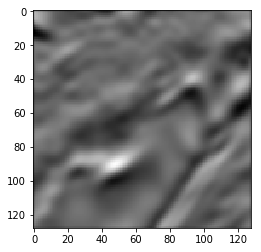

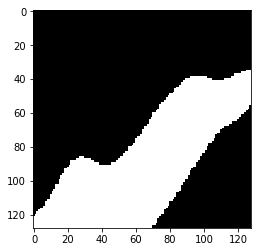

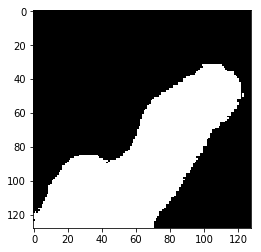

In [21]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
plt.imshow(np.dstack((X_train[ix],X_train[ix],X_train[ix])))
plt.show()
tmp = np.squeeze(Y_train[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()
tmp = np.squeeze(preds_train_t[ix]).astype(np.float32)
plt.imshow(np.dstack((tmp,tmp,tmp)))
plt.show()

# 説明文

# 1. 過学習の抑制

## 1.1. Batch Normalizationについて
[\[1502.03167\]Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)<br>


2015年に Google の Loffe さんらによって提案された手法。<br>
ニューラルネットワークの各活性化関数における出力（activation）の分布が偏っていると色々問題を起こす可能性がある。例えば 0, 1 付近に集中していたりすると勾配消失問題が起こりやすくなり、かといって他の特定の箇所に集中していても今度は表現力がなくなってしまい複数のニューロンが存在する意味がなくなってしまう。<br>

解決法として活性化関数に応じた以下のような初期値設定法が提案されている。

- 活性化関数が Sigmoid, tanh の場合
  - Xavier の初期値
- 活性化関数が ReLU の場合
  - He の初期値

適切な初期値の設定とはまた別として、分布に適度な広がりをもたせたい、そこで Batch Normalization が考案されている。
具体的には

- 学習係数を適度に大きくし学習の進行速度を上げられる
- 初期値にそれほど依存しない
- 過学習を抑制する

などの利点がある。実際の処理はデータ値の平滑化を行っている。以下に全結合時とCNNの場合の処理を図で示す。

### 全結合の場合
全結合のニューラルネットワークの場合、Affinの後、活性化(例:ReLU)の前
![](https://camo.qiitausercontent.com/9bec462de1ec69e9743678ae1f6b8a43b51f9a41/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f35656539616531342d353734662d393335332d346235622d3434613561323534326365662e706e67)
Affinの出力を 行 として、
（図は入力層→NN第一層での例）
![](https://camo.qiitausercontent.com/3f41a9a11bd75159e6823cb490df50d57aafd444/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f30386562373930362d323639642d633964352d303162302d3861313732353338646239362e706e67)
ミニバッチ数分のAffin出力を並べた行列が入力。
![](https://camo.qiitausercontent.com/ca2e14de1d76992c6818111929fd3f4e2e231683/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f33303063646162312d303934662d346337362d633637612d6564656663616631373137392e706e67)
入力行列をミニバッチ方向に要素毎（列内）で正規化の演算。
![](https://camo.qiitausercontent.com/291ffa67dc4de7b664dc6d1c263217085f7d00c9/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f36373939336161612d303236302d373262342d366336362d6263613863626563323161372e706e67)

### CNNの場合
CNNの場合、Convolutionの後、活性化(例:ReLU)の前
![](https://camo.qiitausercontent.com/7d0026bb84cb683903441a53fb68e7ef8022fe72/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f31393730656161622d623162642d306539322d353630362d3235343963343866396438302e706e67)
Convolution の出力の チャンネルをシリアライズし１行とし、
![](https://camo.qiitausercontent.com/1588fc2148f68f696d7db74259fa1c23b9e3c6f5/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3136393538392f39363839333036362d393136372d666637362d633764332d6234616438336636623562662e706e67)
ミニバッチ数の行数とした行列。

以後の計算は、全結合のBatch Normalization と同じ。

## 1.2. その他過学習を抑制する手法について

### ウェイトディケイ　(正則化)
ウェイトディケイ、重み減衰、あるいは正則化などと呼ばれるテクニックは非常に広く使われている。損失関数に全ての重みの絶対値の総和=L1 Weight Decay(L1正則化)あるいは全ての重みの二乗値の総和=L2 Weight Decay(L2正則化)を係数を掛けて足す。（計算にはバイアスは含めず、基本的にはL2正則可よくが使用される）

単純だが、パラメータの発散を防いで過学習状態を防ぐ強い効果がある。

### ドロップアウト

これは学習時にランダムにノードのうち幾つかを全く使用せずに出力とバックプロパゲーションを行う。これによりノード間の依存関係を減らしモデルが過学習してしまうことを防ぐ。ただし通常よりも学習が遅くなってしまうという欠点もある。

![](https://camo.qiitausercontent.com/6c1c079af5284619295b15f97dbd233cfca67bb7/68747470733a2f2f71696974612d696d6167652d73746f72652e73332e616d617a6f6e6177732e636f6d2f302f3134353637352f35626636363830382d343239392d623135632d356664632d6538646330383962313761312e6a706567)

また本質的にはアンサンブル学習と近い意味がある。

### ハイパーパラメータの学習、自動調整

学習係数の大きさやCNNあるいはノード（特徴量）のサイズ、隠れ層の数は重要だが、それ以外にも上で述べたようにドロップアウトやウェイトディケイの係数、バッチの大きさや利用するオプティマイザの種類・モーメントの強さなど沢山のハイパーパラメータがある。

モデルについては、例えば精度が出なくなったらレイヤーを広く(ノードの数を大きく)して、過学習しはじめたらレイヤーを狭くしながら深くする（レイヤーを追加する）のを試すなど、それぞれのパラメータを調節するための指針はある。しかし実際に調節して試していくには大きな時間がかかる。

これらの各ハイパーパラメータを自動で調整する機構をつけるケースも増えている。トレーニングデータや実際の評価用（テスト）データに対してバリデーションデータとして別のデータセットを追加し、この損失勾配からハイパーパラメータを自動調整する手法。

## 1.3. 今回のsprintで実践したことについて
今回は過学習を防ぐために「early stopping」を追加した。別のU-netモデルで試した際には、「Batch Normalization」とDropを追加した。「Batch Normalization」を追加したことにより、学習速度と損失が向上した。

# 2. 転移学習とファインチューニング

## 2.1. 転移学習とファインチューニングの意味の違いについて
違いは以下になる。 

- 転移学習：既存の学習済モデル（出力層以外の部分）を、重みデータは変更せずに特徴量抽出機として利用する。
- ファインチューニング：既存の学習済モデル（出力層以外の部分）を、重みデータを一部再学習して特徴量抽出機として利用する。

（出力層付近以外を）再学習させないのが転移学習、させるのがファインチューニング。

## 2.2 ImageNetによる事前学習モデルについて
ImageNet による事前学習モデルを使用することには以下のメリットがある。
ImageNetによる事前学習について再考した論文[「Rethinking ImageNet Pre-training」](https://arxiv.org/abs/1811.08883)によると、「ImageNetによる事前学習済みモデルは学習の収束を早める」ことがわかっている。だからと言って必ずしも必要とは限らない。理由と以下の点がある。

- 論文の実験はImageNetが収束を早めることができるが、学習データが少なすぎる場合を除いて必ずしも精度を向上させるとは限らないことを示している。
- 十分な量の学習データ（および計算）があればよい。データセットが十分に大きい場合は、学習データを直接使うだけで十分。
- 学習データのannotationを収集するのに注力することの方が、目的のタスクのパフォーマンスを向上させる上でより効果的であることを示唆している。

## 2.3 事前学習モデルの選び方について
事前学習モデルは実行したいタスク、物体検出なのか、セグメンテーション等によって異なる。また、実行する環境資源によっても異なる。資源豊富であれば、精度が高いが計算コストが高いモデルを使用することができる。しかし、資源が限られている場合は、精度が低くなるが計算コストが低いモデルを選ぶ必要がある。

# 3. Early Stopping
## 3.1 エポック数とは
エポック数とは、「一つの訓練データを何回繰り返して学習させるか」の数のこと。<br>
Deep Learningのようにパラメータの数が多いものになると、訓練データを何回も繰り返して学習させないとパラメータをうまく学習できない(逆にやりすぎると過学習になる)。

多すぎずに少なすぎないエポック数を指定することによって、パラメーターをうまく学習させることができる。

## 3.2「良い」エポック数とは
学習の最終的な目標は、「汎化性能があるパラメータ集合を見つけること」。そのため、訓練データへの精度が高く、且つ予測精度が高くなるように学習させてやることが重要。

よって、過学習を起こさずに、かつ訓練精度と予測精度が共に良いような、そんなエポック数を見つけることができれば、良いエポック数ということになる。
<img src="https://cdn-ak.f.st-hatena.com/images/fotolife/S/St_Hakky/20170117/20170117165040.png" width=55%>
上図のように、予測精度が識別精度の少し下あたりで落ち着きだしたエポック数を取得することができるのが理想で、その時のエポック数が適当なエポック数となる。

## 3.3 Early Stopping
学習がある程度進んだ段階で学習を打ち切る「Early Stopping」というものがある。
これは、簡単に言うと、「学習が進んで精度の向上がこれ以上見込めないとなったら、そこで学習を止める」という方法。学習時に「訓練用のデータ」と「学習を止めるかということを判断するバリデーション用のデータ」に分けておき、そのデータを用いて学習を止めるかどうかという判定をする。